<a href="https://colab.research.google.com/github/oscarserc/VISION_por_COMPUTADORA/blob/main/TransferLearning_CNN_1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wget



  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=4f4fa24003728e124f95d4334b468aca51ee35a77f1ff717b2e962443b5d9f51
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import wget

wget.download('https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/flowers.zip')

'flowers.zip'

In [ ]:
import zipfile

with zipfile.ZipFile('flowers.zip','r') as zip_ref:
  zip_ref.extractall('.')

In [ ]:
import os

PATH = 'flowers'

classes = os.listdir(PATH)
classes

['daisy', 'rose', 'dandelion', 'sunflower', 'tulip']

In [ ]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == 'jpg']
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)


Categoría: daisy. Imágenes: 769
Categoría: rose. Imágenes: 784
Categoría: dandelion. Imágenes: 1055
Categoría: sunflower. Imágenes: 734
Categoría: tulip. Imágenes: 984


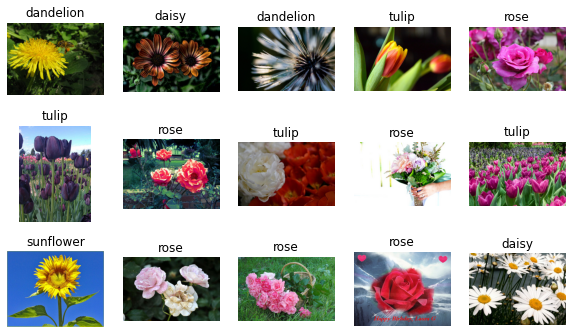

In [ ]:

import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()    


In [ ]:

# PREPARAMOS UN CONJUNTO DE TEST
# ==============================

from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)
len(train_imgs), len(test_imgs)



(3458, 865)

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = io.imread(self.X[ix])
    if self.trans:
      img = self.trans(image=img)['image']
    return torch.from_numpy(img/255.).float().permute(2,0,1), torch.tensor(self.y[ix])    


In [ ]:

import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)               
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test' : Dataset(test_imgs,  test_labels,  trans, device)
}

len(dataset['train']), len(dataset['test'])


(3458, 865)

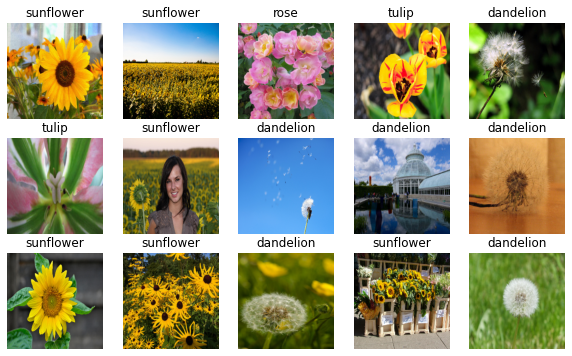

In [ ]:

fig, axs = plt.subplots(3, 5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()    


In [ ]:

# PREPARAMOS PARA LA CARGA DE DATOS
# =================================

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64,  shuffle=True, pin_memory=True),
    'test' : torch.utils.data.DataLoader(dataset['test'],  batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape


torch.Size([64, 3, 224, 224])

## **PREPARAMOS EL MODELO PARA LA TRANSFERENCIA DE APRENDIZAJE**

In [ ]:
import torchvision

resnet = torchvision.models.resnet18()
resnet


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:

class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])

    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False

    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
      param.requires_grad=True        



In [ ]:

model = Model()
salidas = model(torch.randn(63, 3, 224, 224))
salidas.shape


torch.Size([63, 5])

## **ENTRENAMIENTO DEL MODELO**


In [ ]:

from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(1, epochs+1):
    model.train()                     #  <------------  MODO ENTRENAMIENTO
    train_loss, train_acc = [], []
    bar = tqdm(dataloader['train'])

    for batch in bar:
      X, y = batch
      X, y = X.to(device), y.to(device)

      y_hat = model(X)
      loss  = criterion(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
      train_acc.append(acc)
      train_loss.append(loss.item())
      bar.set_description(f'loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}')

    bar = tqdm(dataloader['test'])
    val_loss, val_acc = [], []
    model.eval()                       #  <------------ MODE TEST  
    with torch.no_grad():
      for batch in bar:
        X, y = batch
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)

        acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
        val_acc.append(acc)
        val_loss.append(loss.item())
        bar.set_description(f'val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}')
    print(f'Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}')    


In [ ]:
model = Model()
fit(model, dataloader, epochs=3)

val_loss 1.66380 val_acc 0.28096: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch 1/3 loss 1.34057 val_loss 1.66380 acc 0.44176 val_acc 0.28096


val_loss 3.36464 val_acc 0.27974: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 2/3 loss 1.13486 val_loss 3.36464 acc 0.55455 val_acc 0.27974


val_loss 1.59865 val_acc 0.45308: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

Epoch 3/3 loss 1.03507 val_loss 1.59865 acc 0.59915 val_acc 0.45308
